<a href="https://colab.research.google.com/github/Sunday-Okey/AIND-Machine-Translation/blob/master/NLP_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import the libraries
import collections
import re
import numpy as np
from keras import optimizers

from keras.preprocessing.text import Tokenizer
# from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import LSTM, GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout
from tensorflow.keras.layers import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.models import load_model
import os
import string
import requests
from keras.utils import pad_sequences
import unicodedata
from keras.callbacks import ModelCheckpoint
import regex

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pwd

'/content'

In [4]:
import os

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/NLP_Final_Project/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)



Your working directory was changed to /content/drive/My Drive/Colab Notebooks/NLP_Final_Project/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


### Extract the file

In [5]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text


In [6]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t')[:-1] for i in sents]
    return sents

In [7]:
pwd

'/content/drive/My Drive/Colab Notebooks/NLP_Final_Project'

In [8]:
data = read_text("fra.txt")
frn_eng = to_lines(data)
# frn_eng[:210000][-3]
frn_eng

[['Go.', 'Va !'],
 ['Go.', 'Marche.'],
 ['Go.', 'En route !'],
 ['Go.', 'Bouge !'],
 ['Hi.', 'Salut !'],
 ['Hi.', 'Salut.'],
 ['Run!', 'Cours\u202f!'],
 ['Run!', 'Courez\u202f!'],
 ['Run!', 'Prenez vos jambes à vos cous !'],
 ['Run!', 'File !'],
 ['Run!', 'Filez !'],
 ['Run!', 'Cours !'],
 ['Run!', 'Fuyez !'],
 ['Run!', 'Fuyons !'],
 ['Run.', 'Cours\u202f!'],
 ['Run.', 'Courez\u202f!'],
 ['Run.', 'Prenez vos jambes à vos cous !'],
 ['Run.', 'File !'],
 ['Run.', 'Filez !'],
 ['Run.', 'Cours !'],
 ['Run.', 'Fuyez !'],
 ['Run.', 'Fuyons !'],
 ['Who?', 'Qui ?'],
 ['Wow!', 'Ça alors\u202f!'],
 ['Wow!', 'Waouh\xa0!'],
 ['Wow!', 'Wah\xa0!'],
 ['Duck!', 'À terre\xa0!'],
 ['Duck!', 'Baisse-toi\xa0!'],
 ['Duck!', 'Baissez-vous\xa0!'],
 ['Fire!', 'Au feu !'],
 ['Help!', "À l'aide\u202f!"],
 ['Hide.', 'Cache-toi.'],
 ['Hide.', 'Cachez-vous.'],
 ['Jump!', 'Saute.'],
 ['Jump.', 'Saute.'],
 ['Stop!', 'Ça suffit\u202f!'],
 ['Stop!', 'Stop\u202f!'],
 ['Stop!', 'Arrête-toi !'],
 ['Wait!', 'Attends !'],


In [9]:
ascii_string = regex.sub(r'[^\x00-\x7f]', r'', "«\xa0Je pense qu'on ne devrait pas faire ça.\xa0» «\xa0Personne ne vous a demandé votre avis.\xa0»")
ascii_string

"Je pense qu'on ne devrait pas faire a. Personne ne vous a demand votre avis."

In [10]:
unicodedata.normalize("NFKD", 'Cours\u202f!')

'Cours !'

In [11]:
frn_eng = frn_eng[:210000]
len(frn_eng)

210000

Lets read in the data

In [12]:
# Open a file in append mode
with open('small_vocab_en', 'a') as file1, open('small_vocab_fr', 'a') as file2:
  for i in range(len(frn_eng)):
      file1.write(frn_eng[i][0] + '\n')
      file2.write(frn_eng[i][1] + '\n')


In [13]:
def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r", encoding='utf-8') as f:
        data = f.read()

    return data.split('\n')

In [14]:
# Load English data
english_sentences = load_data('small_vocab_en')
# Load French data
french_sentences = load_data('small_vocab_fr')

In [15]:
len(english_sentences)

347861

In [16]:
len(french_sentences)

347861

In [17]:
# Remove punctuation
english_sentences = [s.translate(str.maketrans('', '', string.punctuation)) for s in english_sentences]
french_sentences = [s.translate(str.maketrans('', '', string.punctuation)) for s in french_sentences]

In [18]:
# convert to lowercase
for i in range(len(english_sentences)):
    english_sentences[i] = english_sentences[i].lower()
    
    french_sentences[i] = french_sentences[i].lower()

    english_sentences[i] = regex.sub(r'[^\x00-\x7f]', r'', english_sentences[i])
    french_sentences[i] = regex.sub(r'[^\x00-\x7f]', r'', french_sentences[i])

In [19]:
# empty lists
eng_l = []
frn_l = []

# populate the lists with sentence lengths
for i in english_sentences:
    eng_l.append(len(i))

for i in french_sentences:
    frn_l.append(len(i))

In [20]:
max(eng_l)

100

In [21]:
max(frn_l)

111

In [22]:
import pandas as pd
length_df = pd.DataFrame({'eng':eng_l, 'frn':frn_l})

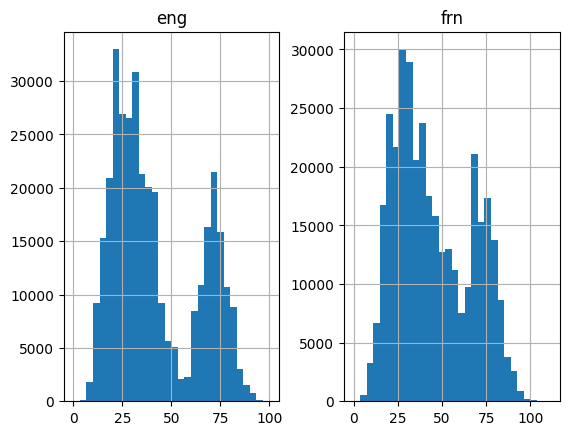

In [23]:
import matplotlib.pyplot as plt
length_df.hist(bins = 30)
plt.show()

In [24]:
print(max(eng_l), max(frn_l))

100 111


In [25]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [26]:
# prepare english tokenizer
eng_tokenizer = tokenization(english_sentences)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 100
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 15251


In [27]:
# prepare French tokenizer
frn_tokenizer = tokenization(french_sentences)
frn_vocab_size = len(frn_tokenizer.word_index) + 1

frn_length = 111
print('French Vocabulary Size: %d' % frn_vocab_size)

French Vocabulary Size: 29519


In [28]:
#encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [29]:
from sklearn.model_selection import train_test_split
frn_train, frn_test1, eng_train, eng_test1 = train_test_split(french_sentences,english_sentences, test_size=0.01, random_state = 12)


In [30]:
len(frn_train)

344382

In [31]:
len(frn_test1)

3479

In [32]:
len(eng_train)

344382

In [33]:
len(eng_test1)

3479

In [34]:
# prepare training data
frn_train = encode_sequences(frn_tokenizer, frn_length, frn_train)
eng_train = encode_sequences(eng_tokenizer, eng_length, eng_train)

In [35]:
# prepare validation data
frn_test = encode_sequences(frn_tokenizer, frn_length, frn_test1)
eng_test = encode_sequences(eng_tokenizer, eng_length, eng_test1)

In [36]:

def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(Bidirectional(GRU(units, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(units)))
    model.add(RepeatVector(out_timesteps))
    model.add(Bidirectional(GRU(units, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Dense(out_vocab, activation='softmax'))

    return model

In [37]:
model = build_model(frn_vocab_size, eng_vocab_size, frn_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 111, 512)          15113728  
                                                                 
 bidirectional (Bidirectiona  (None, 111, 1024)        3151872   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 1024)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1024)             4724736   
 nal)                                                            
                                                                 
 repeat_vector (RepeatVector  (None, 100, 1024)        0         
 )                                                               
                                                        

In [39]:
frn_train.shape

(344382, 111)

In [40]:
eng_train.shape

(344382, 100)

In [41]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(frn_train, eng_train.reshape(eng_train.shape[0], eng_train.shape[1], 1),epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], verbose=1)

Epoch 1/30
538/539 [============================>.] - ETA: 0s - loss: 0.4545
Epoch 1: val_loss improved from inf to 0.28884, saving model to model.h1.24_jan_19


539/539 [==============================] - 185s 302ms/step - loss: 0.4545 - val_loss: 0.2888
Epoch 2/30
538/539 [============================>.] - ETA: 0s - loss: 0.2223
Epoch 2: val_loss improved from 0.28884 to 0.17181, saving model to model.h1.24_jan_19


539/539 [==============================] - 158s 292ms/step - loss: 0.2223 - val_loss: 0.1718
Epoch 3/30
538/539 [============================>.] - ETA: 0s - loss: 0.1413
Epoch 3: val_loss improved from 0.17181 to 0.12416, saving model to model.h1.24_jan_19


539/539 [==============================] - 158s 293ms/step - loss: 0.1413 - val_loss: 0.1242
Epoch 4/30
538/539 [============================>.] - ETA: 0s - loss: 0.1118
Epoch 4: val_loss improved from 0.12416 to 0.10823, saving model to model.h1.24_jan_19


539/539 [==============================] - 157s 291ms/step - loss: 0.1118 - val_loss: 0.1082
Epoch 5/30
538/539 [============================>.] - ETA: 0s - loss: 0.0965
Epoch 5: val_loss improved from 0.10823 to 0.10050, saving model to model.h1.24_jan_19


539/539 [==============================] - 157s 292ms/step - loss: 0.0965 - val_loss: 0.1005
Epoch 6/30
538/539 [============================>.] - ETA: 0s - loss: 0.0862
Epoch 6: val_loss improved from 0.10050 to 0.09511, saving model to model.h1.24_jan_19


539/539 [==============================] - 158s 292ms/step - loss: 0.0862 - val_loss: 0.0951
Epoch 7/30
538/539 [============================>.] - ETA: 0s - loss: 0.0782
Epoch 7: val_loss improved from 0.09511 to 0.09100, saving model to model.h1.24_jan_19


539/539 [==============================] - 157s 292ms/step - loss: 0.0782 - val_loss: 0.0910
Epoch 8/30
538/539 [============================>.] - ETA: 0s - loss: 0.0695
Epoch 8: val_loss improved from 0.09100 to 0.08992, saving model to model.h1.24_jan_19


539/539 [==============================] - 158s 293ms/step - loss: 0.0695 - val_loss: 0.0899
Epoch 9/30
538/539 [============================>.] - ETA: 0s - loss: 0.0639
Epoch 9: val_loss improved from 0.08992 to 0.08738, saving model to model.h1.24_jan_19


539/539 [==============================] - 158s 293ms/step - loss: 0.0639 - val_loss: 0.0874
Epoch 10/30
538/539 [============================>.] - ETA: 0s - loss: 0.0592
Epoch 10: val_loss did not improve from 0.08738
539/539 [==============================] - 105s 194ms/step - loss: 0.0592 - val_loss: 0.0877
Epoch 11/30
538/539 [============================>.] - ETA: 0s - loss: 0.0548
Epoch 11: val_loss improved from 0.08738 to 0.08592, saving model to model.h1.24_jan_19


539/539 [==============================] - 157s 292ms/step - loss: 0.0548 - val_loss: 0.0859
Epoch 12/30
538/539 [============================>.] - ETA: 0s - loss: 0.0513
Epoch 12: val_loss improved from 0.08592 to 0.08584, saving model to model.h1.24_jan_19


539/539 [==============================] - 157s 292ms/step - loss: 0.0513 - val_loss: 0.0858
Epoch 13/30
538/539 [============================>.] - ETA: 0s - loss: 0.0489
Epoch 13: val_loss did not improve from 0.08584
539/539 [==============================] - 105s 194ms/step - loss: 0.0489 - val_loss: 0.0862
Epoch 14/30
538/539 [============================>.] - ETA: 0s - loss: 0.0457
Epoch 14: val_loss did not improve from 0.08584
539/539 [==============================] - 105s 194ms/step - loss: 0.0457 - val_loss: 0.0868
Epoch 15/30
538/539 [============================>.] - ETA: 0s - loss: 0.0438
Epoch 15: val_loss did not improve from 0.08584
539/539 [==============================] - 104s 194ms/step - loss: 0.0438 - val_loss: 0.0872
Epoch 16/30
538/539 [============================>.] - ETA: 0s - loss: 0.0415
Epoch 16: val_loss did not improve from 0.08584
539/539 [==============================] - 105s 194ms/step - loss: 0.0415 - val_loss: 0.0868
Epoch 17/30
538/539 [==========

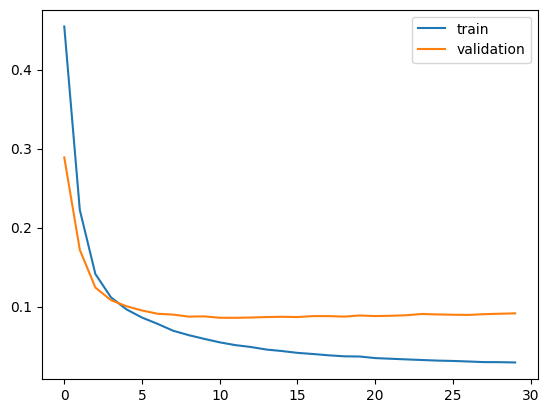

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [55]:
model = load_model('model.h1.24_jan_19')

In [43]:
import numpy as np

def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [44]:
test_x = frn_test.reshape((frn_test.shape[0],frn_test.shape[1]))
test_x[:4][1]

array([  21,  213,    9,    5,  472,    9,   19,   13,  144, 2678,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [45]:
test = ['Elle étudie pour devenir médecin.', 'Le restaurant sert une nourriture délicieuse.']

In [46]:
test = encode_sequences(frn_tokenizer, frn_length, test)
test = test.reshape((test.shape[0],test.shape[1]))

In [47]:
test

array([[  28,   76,  850,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   8,  909, 1735,   41,  578,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

In [48]:
# print(logits_to_text(model.predict(test_x[:4][1], eng_tokenizer)))
# print(logits_to_text(model.predict(frn_test[:20])[10], eng_tokenizer))

print(logits_to_text(model.predict(test_x[:4])[3], eng_tokenizer))

1/1 [==============================] - 7s 7s/step
im willing to apologize <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [49]:
test_x

array([[  3, 367, 128, ...,   0,   0,   0],
       [ 21, 213,   9, ...,   0,   0,   0],
       [ 10,  70,  66, ...,   0,   0,   0],
       ...,
       [ 10, 129,  13, ...,   0,   0,   0],
       [  5,  47,   1, ...,   0,   0,   0],
       [ 77,   1, 124, ...,   0,   0,   0]], dtype=int32)

In [50]:
frn_test1[3]

'je veux prsenter mes excuses'

In [51]:
eng_test1[3]

'i want to apologize'

In [52]:
import os 

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/NLP_Final_Project/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/NLP_Final_Project/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [53]:
import os

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/NLP_Final_Project/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)



Your working directory was changed to /content/drive/My Drive/Colab Notebooks/NLP_Final_Project/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [54]:
pwd

'/content/drive/My Drive/Colab Notebooks/NLP_Final_Project'